In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Quantum Fourier Transform

$$\text{QFT} = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} \sum_{y = 0}^{N - 1} \exp\left(i \frac{2\pi x y}{N}\right) |y\rangle \langle x|$$.

$$x = 2^{n - 1} x_{n-1} + 2^{n - 2}x_{n-2} + \ldots + 2^1 x_1 + 2^0 x_0$$

$$|x\rangle = |x_{n - 1}\rangle \otimes |x_{n - 2}\rangle \otimes \cdots \otimes |x_0\rangle = |x_{n-1} x_{n-2} \ldots x_{0} \rangle$$

$$N = 2^n$$

Goal is to implement the QFT unitary on our quantum register.

Key identity for finding the decomposition
$$|\tilde{x}\rangle = \text{QFT} |x\rangle = \frac{1}{\sqrt{N}} \sum_{y = 0}^{N-1} \exp\left(i \frac{2\pi x y}{N}\right) |y\rangle = \frac{1}{\sqrt{N}}\left(|0\rangle + \exp\left(i\frac{2\pi x}{2}\right) |1\rangle\right) \otimes \left(|0\rangle + \exp\left(i\frac{2\pi x}{2^2}\right) |1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + \exp\left(i\frac{2\pi x}{2^n}\right)|1\rangle\right)$$

Also
$$\exp\left(i\frac{2\pi x}{2^m}\right) = \exp\left(i\frac{2\pi}{2^m}\left(2^{m - 1}x_{m - 1} + 2^{m - 2} x_{m-2} + \ldots + 2 x_1 + x_0\right)\right) = \exp\left(i\sum_{l = 0}^{m - 1} \phi_{ml} x_l\right)$$

$$\phi_{ml} = \frac{\pi}{2^{m - l - 1}}$$

## Task 1

Create a quantum circuit which transforms the single qubit state $|x\rangle$ $x \in \{0, 1\}$ to $\frac{1}{\sqrt{2}}\left(|0\rangle + \exp\left(i \pi x\right)|1\rangle\right)$.

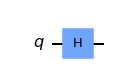

In [2]:
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.draw("mpl")

## Controlled phase gate

Simple phase gate: $P(\phi)|x\rangle = e^{i\phi x} |x\rangle$, $x \in \{0, 1\}$

Controlled phase gate: $CP(\phi) |xy\rangle = e^{i\phi xy} |xy\rangle$, $x, y \in \{0, 1\}$


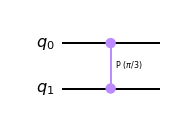

In [3]:
qc2 = QuantumCircuit(2)
qc2.cp(np.pi / 3, 0, 1)
qc2.draw("mpl")

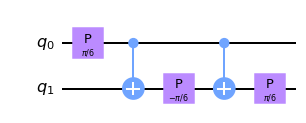

In [5]:
qc2.decompose().draw("mpl")

## Task 2

Create a quantum circuit that transforms $|x_{1} x_{0} \rangle$ to $\frac{1}{\sqrt{2}}\big[|0\rangle + \exp(i\phi_{21} x_1 + i\phi_{20} x_0) |1\rangle\big] |x_{0} \rangle = \frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(i \frac{2\pi x}{2^2}\right) |1\rangle\right] | x_{m-2} x_{m - 3} \ldots x_0\rangle$.

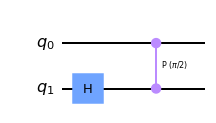

In [6]:
qc3 = QuantumCircuit(2)
qc3.h(1)
qc3.cp(np.pi/2,0, 1)
qc3.draw("mpl")

## Task 3

Create a quantum circuit for the transformation 
$$|x_{m-1} x_{m-2} \ldots x_0\rangle \rightarrow \frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(i \sum_{l = 0}^{m-1} \phi_{ml} x_l\right) |1\rangle\right] | x_{m-2} x_{m - 3} \ldots x_0\rangle = \frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(i \frac{2\pi x}{2^m}\right) |1\rangle\right] | x_{m-2} x_{m - 3} \ldots x_0\rangle$$

In [3]:
def qft_m(m):
    qc = QuantumCircuit(m)
    qc.h(m - 1)
    for l in range(m - 1):
        qc.cp(np.pi / 2**(m - l - 1), l, m - 1)
    return qc

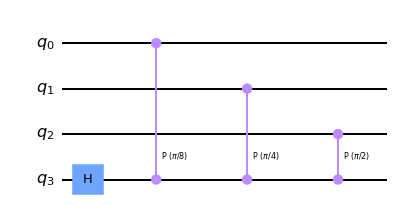

In [8]:
qft_m(4).draw("mpl")

## Swap gate
Applying the previous circuit repeatedly with decreasing $m$ from $n - 1$ to $0$ on the state $|x_{n - 1} x_{n - 2} \ldots x_0\rangle$ we get the state 

$$\frac{1}{\sqrt{N}}\left[|0\rangle + \exp\left(i \frac{2\pi x}{2^n}\right) |1\rangle\right] \otimes \left[|0\rangle + \exp\left(i \frac{2\pi x}{2^{n-1}}\right) |1\rangle\right] \otimes \cdots \otimes \left[|0\rangle + \exp\left(i \frac{2\pi x}{2}\right) |1\rangle\right]$$.

What is the difference between the state above and the state $|\tilde{x}\rangle$? The answer is that only the order of the qubits is different. We can reorder states using the swap gate $\text{SWAP} |xy\rangle = |yx\rangle$

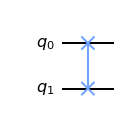

In [9]:
qc4 = QuantumCircuit(2)
qc4.swap(0, 1)
qc4.draw("mpl")

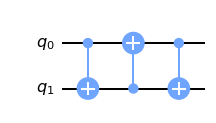

In [10]:
qc4.decompose().draw("mpl")

## Task 4

Implement the QFT on $n$ qubits.

In [4]:
def qft(n):
    qc = QuantumCircuit(n)
    for m in range(n):
        qc.compose(qft_m(n - m), range(n - m), inplace = True)
    for m in range(n // 2):
        qc.swap(m, n - 1 - m)
    return qc

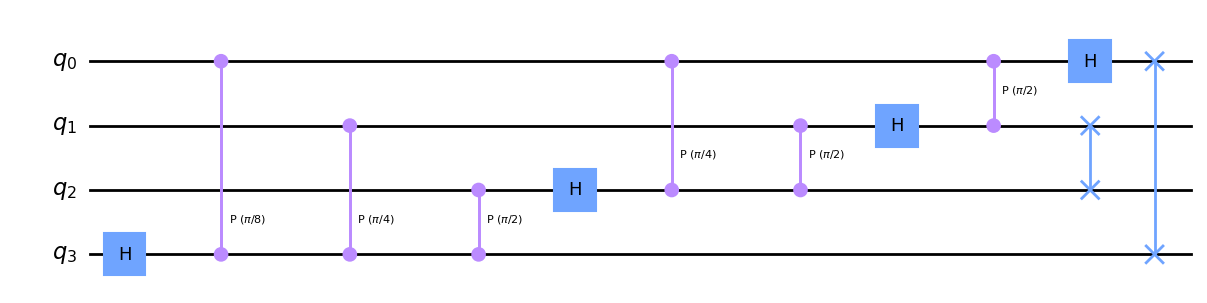

In [5]:
qft(4).draw("mpl")

## Task 5

Simulate and check that the circuit works as expected.

In [6]:
def create_state(k, n):
    N = 2**n
    psi = np.zeros(N, dtype = complex)
    for l in range(N):
        psi[l] = np.exp(2j * np.pi * k * l / N) / np.sqrt(N)
    return psi

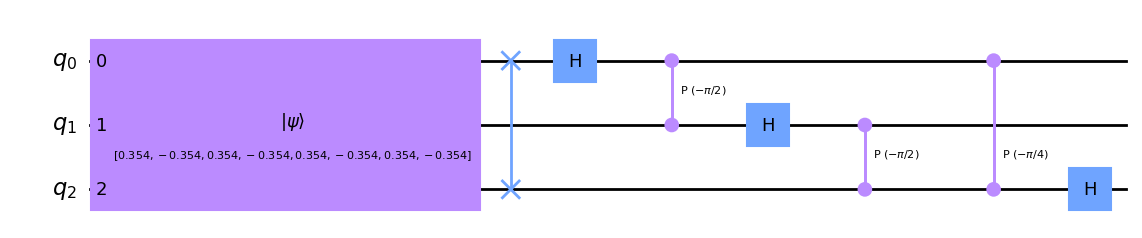

In [7]:
qc = QuantumCircuit(3)
qc.initialize(create_state(4, 3), range(3))
qc.compose(qft(3).inverse(), inplace = True)
qc.draw("mpl")

In [8]:
statevector_sim = Aer.get_backend("statevector_simulator")

In [9]:
state = execute(qc, backend = statevector_sim).result().get_statevector()
state

Statevector([ 1.11022302e-16+1.22464680e-16j,
             -5.94596577e-17+6.50436891e-17j,
             -1.31100821e-16+5.25961985e-17j,
             -2.12540508e-16+9.53253786e-18j,
              1.00000000e+00-6.12323400e-16j,
              1.57029356e-16+1.43548312e-16j,
              5.25961985e-17+1.31100821e-16j,
              3.94850647e-18+8.80371608e-17j],
            dims=(2, 2, 2))


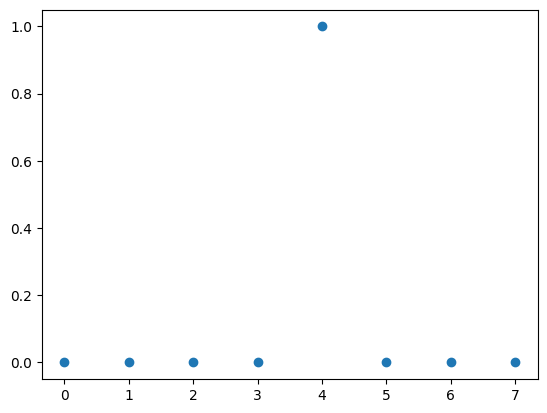

In [10]:
plt.scatter(range(8), abs(np.array(state)))